# Naive Bayes i Classificació


En aquest tercer lliurament es programarà un classificador, que donat un tweet el categoritzarà en una de les possibles classes. En aquesta ocasió, implementareu un classificador amb tweets de polítics.


**Què s’ha de fer?**

Volem classificar tweets corresponents a diferents politics segons a quin partit polític pertanyen. 
A partir de tots els tweets que tenim, crearem un vector de característiques que ens descrigui cada un dels tweets. 
Finalment desenvoluparem un classificador probabilístic del tipus Naive Bayes que ens permeti identificar a quin partit polític pertany un tweet donat segons les característiques triades.


**Quina és la idea del sistema de classificació que s’ha de desenvolupar?**

El classificador és un concepte de l'aprenentatge automàtic supervisat. 
L'objectiu del classificador és donat un vector de característiques que descriuen els objectes que es volen classificar indicar a quina categoria o classe pertanyen d'entre un conjunt predeterminat. 
El procés de classificació consta de dues parts: 
(a) el procés d'aprenentatge i 
(b) el procés d'explotació o testeig. 
El procés d'aprenentatge rep exemples de parelles $(x,y)$ on $x$ són les característiques, usualment nombres reals, i $y$ és la categoria a la que pertanyen. 
Aquest conjunt se'l coneix com a conjunt d'entrenament i ens servirà per trobar una funció $\hat{y}=h(x)$ que donada una $x$ aconsegueixi que $\hat{y}=y$. Per altra banda el procés de testeig aplica la funció $h(x)$ apresa a l'entrenament a una nova descripció per veure quina categoria li correspon.


**Classificació i llenguatge natural**

La descripció dels exemples en característiques és el punt més crític de tot sistema d'aprenentatge automàtic. 
Una de les representacions més simples per tal de descriure un text és la representació *bag-of-words*.
Aquesta representació converteix un text en un vector de $N$ paraules. 
Consisteix en seleccionar un conjunt d'$N$ paraules i per cada paraula comptar quants cops apareix en el text. 
Una versió alternativa d'aquest procés pot ser simplement indicar si apareix o no en el text.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy` i `NLTK`

*Nota: A més de les que ja es troben presents en la 1a cel·la i funcions natives de Python*

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica què serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. 

# Preparar les dades

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import zipfile
import pickle
from os.path import join as path, dirname

try:
    from IPython.core.display import HTML

    def pprint(df):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(HTML(pd.DataFrame(df).to_html()))
except:
    def pprint(df):
        print(df)

In [3]:
pip install xlrd


The following command must be run outside of the IPython shell:

    $ pip install xlrd

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [4]:
print('Training data')
df_tweets_train = pd.read_excel(path('data', 'train.xlsx'), index_col='Id')
pprint(df_tweets_train.head())
print(df_tweets_train.shape)

print('Test data')
df_tweets_test = pd.read_excel(path('data', 'test.xlsx'), index_col='Id')
pprint(df_tweets_test.head())
print(df_tweets_test.shape)

Training data


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
0,martarovira,erc,Últim acte de campanya! Aquí tossudament alçat...,2017-12-19 20:12:01,785,2295
1,xavierdomenechs,comuns,#Badalona necessita uns pressupostos que posin...,2018-04-27 10:04:19,55,93
2,albert_rivera,cs,Encuentro Villacís-Valls para lanzar una estra...,2018-11-17 20:34:58,357,622
3,jaumecollboni,psc,"“La palabra es como una bala, no tiene retorno...",2018-10-22 18:10:01,4,6
4,albiol_xg,ppc,"📻 Esta noche, a partir de las 22:10h, me entre...",2018-08-16 10:30:27,20,47


(1920, 6)
Test data


,text,retweet_count,favorite_count
Id,,,
0,Avui hem représ la Comissió Mixta amb el @gove...,67,103
1,"Torra anunció un ""otoño caliente"" para aumenta...",856,1501
2,Demà cal sortir als carrers per dir que #Barce...,144,174
3,“Cercàvem or i vam baixar a la mina.\nI la fos...,338,1560
4,"Molt senzill d'entendre, companya: \n1.- L'ALL...",4932,7253


(480, 3)


# Implementació

Dividirem el notebook en 3 seccions que es complementen una a l'altra:

1. Anàlisis de dades: Informació bàsica sobre els tweets
2. Processament de les dades: Creació d'un vector de característiques a partir dels tweets
3. Classificació amb Naive Bayes

### Anàlisis de dades

El primer que haurem de fer és analitzar les dades mitjançant diferents funcions.

In [5]:
def count_tweets(df):
    """
    Retorna el número de tweets en el dataframe
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : número de tweets
    """
    return df.shape[0]

def get_politicians(df):
    """
    Retorna els usuaris dels polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels usuaris
    """
    #utilitzem la funció unique per evitar usuaris repetits
    return df['username'].unique()

def count_politicians(df):
    """
    Retorna la quantitat de polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return len(df['username'].unique())

def get_political_party(df):
    """
    Retorna els partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels partits polítics que han tuitejat
    """
    #utilitzem la funció unique per evitar partits repetits
    return df['party'].unique()

def count_political_party(df):
    """
    Retorna la quantitat de partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return len(df['party'].unique())

def count_tweet_politician(df):
    """
    Retorna la quantitat de tweets per polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per polític
    """
    return df.groupby(['username'],sort=False).size()

def count_tweet_party(df):
    """
    Retorna la quantitat de tweets per partit polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per partit polític
    """
    return df.groupby(['party'],sort=False).size()

def top_retweet(df, n):
    """
    Retorna els n tweets que han sigut més retuitejats
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top retweets
    """
    return df.sort_values(by=['retweet_count'],ascending=False)[:n]
    
def top_favorite(df, n):
    """
    Retorna els n tweets més favorits
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top favorits
    """
    return df.sort_values(by=['favorite_count'],ascending=False)[:n]

1920
['martarovira' 'xavierdomenechs' 'albert_rivera' 'jaumecollboni'
 'albiol_xg' 'miqueliceta' 'quimtorraipla' 'adacolau' 'santirodriguez'
 'krls' 'joantarda' 'inesarrimadas'] 12
['erc' 'comuns' 'cs' 'psc' 'ppc' 'jxcat'] 6


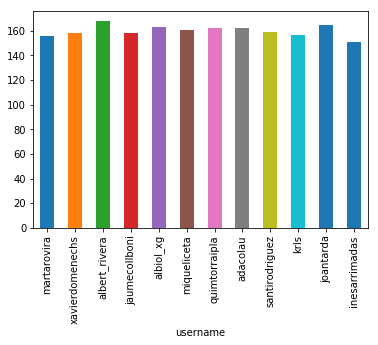

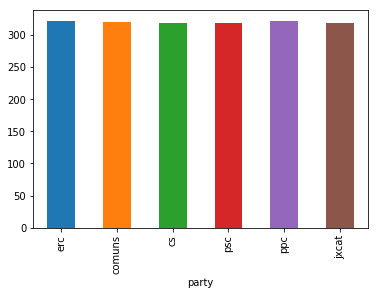

,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,Que una republicana defienda la República es b...,2018-10-26 22:17:38,11706,26838
781,martarovira,erc,A tots els demòcrates: no pararem fins que tor...,2017-11-02 17:42:06,10403,19991
138,krls,jxcat,Una causa que necessiti ser defensada amb cúte...,2018-08-29 20:21:30,10086,20357
1664,martarovira,erc,.@junqueras President d'un partit amb 86 anys ...,2017-12-13 21:17:18,9445,15947
1515,krls,jxcat,"Perdoneu, però això és tan greu que si no hi h...",2018-09-19 20:16:22,8806,12509


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,Que una republicana defienda la República es b...,2018-10-26 22:17:38,11706,26838
138,krls,jxcat,Una causa que necessiti ser defensada amb cúte...,2018-08-29 20:21:30,10086,20357
174,krls,jxcat,Acabo d'arribar a #Escòcia convidat pel Fòrum ...,2018-08-24 17:55:01,6783,20018
781,martarovira,erc,A tots els demòcrates: no pararem fins que tor...,2017-11-02 17:42:06,10403,19991
1043,krls,jxcat,Una gran #Diada2018 per avançar cap a la repúb...,2018-09-11 18:48:43,6372,18950


In [6]:
print(count_tweets(df_tweets_train))
print(get_politicians(df_tweets_train), count_politicians(df_tweets_train))
print(get_political_party(df_tweets_train), count_political_party(df_tweets_train))

count_tweet_politician(df_tweets_train).plot.bar()
plt.show()

count_tweet_party(df_tweets_train).plot.bar()
plt.show()

pprint(top_retweet(df_tweets_train, 5))
pprint(top_favorite(df_tweets_train, 5))

### Comptar paraules

El primer que haurem d'implementar és la funció *normalize* que normalitzarà les paraules.

No modificar la següent cel·la, s'encarrega de guardar una caché de la funció normalize per accelerar el procés.

In [7]:
def memo(f):
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
        
    return memodict(f)

In [8]:
import re
@memo

def normalize(word):
    """
    Funció que donada una paraula la normalitzi
    Exemple: inFO*RmÀ745tica? ---> informatica
    
    :param word: paraula a normalitzar
    :return : paraula normalitzada
    """
    word=word.lower()
    word=re.sub('[0-9]', '', word) #eliminar digits
    word=re.sub(r'[^\w]', '', word) #eliminar simbols 
   #àáâãäåèéêëìíîïòóôõöùúûüýÿçñ
    lista=[('á','a'),('à','a'),('í','i'),('é','e'),('è','e'),('ò','o'),('ó','o'),('ú','u'),('â','a'),('ã','a')
           ,('ä','a')]
    #normalitzar accents
    for i in lista:
        if i[0] in word:
            word = word.replace(i[0],i[1])
    return word

normalize('inFO*RmÀ745tica')

'informatica'

In [9]:
def sentence_to_words(sentence):
    """
    Funció que donada una frase, generi una llista amb totes les seves paraules normalitzades.
    
    :param sentence: frase a transformar
    :return : llista de paraules (no buides) normalitzades
    
    Exemple: **Taller DELS noUS U**SOS    de la inFO#Rm765Àtica? ---> 
        ['taller', 'dels', 'nous', 'usos', 'de', 'la', 'informatica']
    """
    
    return [normalize(i) for i in sentence.split()]

sentence_to_words('**Taller DELS noUS U**SOS    de la inFO#Rm765Àtica?')

['taller', 'dels', 'nous', 'usos', 'de', 'la', 'informatica']

In [10]:
def count_words(df):
    """
    Funció que ha de construir un DataFrame amb índex les paraules normalitzades,
    i columnes n_ocur (nombre de vegades que apareix la paraula a tots els tweets)
    i n_tweets (nombre de tweets on apareix la paraula alguna vegada).
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame especificat.
    """
    #omplim dades en un diccionari i despres convertirlo en un datafram. 
    #Així és molt més eficient que treballar directament amb el dataframe
    tweets=df['text']
    data=dict()
    for tweet in tweets:
        aux=sentence_to_words(tweet)
        repeat=[] #per no repetir n_tweets
        for word in aux:
            #si no hi és al dict, l'afegim
            if word not in data:
                data[word]={'n_ocur':1, 'n_tweets':1}
                repeat.append(word)
            else:
            #mirem si hi es al repeat per incrementar n_tweets
                if word not in repeat:
                    data[word]["n_tweets"]+=1
                    repeat.append(word)
                data[word]["n_ocur"]+=1
                
     #pd.DataFrame(data)
    return pd.DataFrame.from_dict(data, orient='index')


### Contar paraules per partit polític

In [11]:
def count_words_parties(df):
    """
    Funció que ha de construir un DataFrame amb columnes les paraules normalitzades,
    i índex cadascún dels partits, contenint el nombre de vegades que cada paraula
    ha aparegut a tweets del partit.
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame esmentat.
    """
    parties=get_political_party(df)
    data=dict()
    for party in parties:
        tweets=df.loc[(df['party']==party)]['text'] # agafem tots els tweets d'un partit en concret
        tmp=dict() #dict tmp que l'afegirem despres al data
        for tweet in tweets:
            aux=sentence_to_words(tweet) #normalitzar
            for word in aux:
                if word not in tmp:
                    #l'afegim si no esta 
                    tmp[word]=1
                else:
                    #el sumem 1 si ja existeix
                    tmp[word]+=1
        #key=party, value=diccionari de nombre de vegades que cada paraula ha aparegut a tweet del partit.
        data[party]=tmp
        #return un dataframe i convertir els NAN en 0.
    return pd.DataFrame.from_dict(data, orient='index',dtype='int').fillna(0)
words_parties = count_words_parties(df_tweets_train)
words_parties.head()

,ultim,acte,de,campanya,aqui,tossudament,alçats,i,amb,un,...,aplegaven,cridar,promovem,boicots,pompeu,fabra,trobareu,famoses,pronunciades,prada
comuns,1.0,6.0,506,2.0,11,0.0,0.0,325,87,152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cs,0.0,0.0,622,0.0,5,0.0,0.0,11,1,142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
erc,1.0,4.0,357,2.0,2,2.0,2.0,339,88,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jxcat,1.0,2.0,419,3.0,4,0.0,0.0,389,92,95,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ppc,0.0,0.0,467,3.0,8,0.0,0.0,45,27,66,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Paraules més freqüents als tweets


**El problema de com escollir el vector de carecterístiques**

L'elecció de les paraules que formen el vector de característiques és un pas crític. 
En funció de com de bona sigui aquesta descripció, millor funcionarà el sistema. 
Tot i que us deixem a vosaltres la política de creació del vector de característiques us donem una d'exemple. 
Per saber quines paraules fer servir una possible estratègia és agafar aquelles paraules que apareixen entre en un 10 i un 50 percent del total (sense tenir en compte el partit). 
Podeu experimentar variant aquests valors.

In [13]:
index=get_political_party(df_tweets_train)
print(index[0])

erc


In [14]:

#Paraules que no aporten significat i no volem utilitzar
skip_words = ["la","de","i","a","que","què","és","el","les","las","n'","un","una","uns",
              "unes","pel","pels","ha","han","ens","en","per","ho","y","tu",
              "del","amb","d","al","lo","","més","com","fer","hem","als","qui","on","para","con",
              "o","x","té","ja","va","vam","has","los","he","tan","hi","es","dels","no","q","els",
              "por","sobre","només","us","això","se","más","su","aquest","aquests","aquesta","to","esta",
              "mi","van","tot","me","nos","molt","este","como", "ni", "m","pq","the", "of","mas"]

In [15]:
def topNwords(df, words, N, skip=[]):
    """
    Funció que crea un pd.Series amb índex cadascún dels partits,
    i values una llista de les N paraules més representatives 
    (les que apareixen amb més freqüència) de cadascún dels partits polítics.
    
    :param df: DataFrame amb els tweets i la informació associada
    :param words: diccionari amb les paraules i la seva frequencia
    :param N: número de paraules més representatives que volem considerar
    :return : pd.Series resultant.
    """
    '''
    1.sort words segons frequencia
    2.per a cada partit es crea una llista de les N paraules més representatives.
    
    '''
    aux=words
    parties=words.index
    data=dict()
    all_words=words.columns
    for word in skip:
        if word in all_words:
            aux=aux.drop(word,1)
    for party in parties:
        data[party]=aux.T.sort_values([party],ascending=False).T.columns[:N]
    return pd.Series(data) 
    

top_words = topNwords(df_tweets_train, words_parties, 10, skip_words)



De cara a millores, tingueu en compte que també haureu de filtrar aquelles paraules que apareixen en la majoria  de tweets, així com també, les que únicament apareixen en un conjunt molt petit de tweets.

### Vector de Característiques
Creeu el vector de característiques necessari per a fer l’entrenament del Naïve Bayes

In [16]:
def create_features(df, top_words): 
    """
    Funció que crea un vector de característiques necessari per a l'entrenament del classificador Naive Bayes.
    Retorna un DataFrame on cada fila representa el vector de característiques del corresponent tweet.
    
    :params df: DataFrame amb els tweets i la informació associada
    :params top_words: ha de ser el pd.Series que retorna topNWords
    :return : pd.DataFrame resultant.
    """
    tweets=df['text']
    data=dict()
    words=set([word for serie in top_words for word in serie])
    i=0
    aux=df.index.tolist()
    #Per cada tweet
    for tweet in tweets:
        vector=np.zeros(len(words))
        #obtenim les paraules
        tmp=sentence_to_words(tweet)
        j=0
        #Per cada paraula
        for word in words:
            #Si tenim la paraula
            if word in tmp:
                vector[j]+=1
            j+=1
        data[aux[i]]=vector
        i+=1
    #Retornem un dataframe amb les dades obtingudes
    return pd.DataFrame.from_dict(data, orient='index',columns=words)

In [17]:
N = 700 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor.

words_parties = count_words_parties(df_tweets_train)
top_words = topNwords(df_tweets_train, words_parties, N, skip_words)
features = create_features(df_tweets_train, top_words)


### El classificador Naïve Bayes

Un cop tenim una representació necessitem un procés d'aprenentatge que ens permeti passar de la descripció a una categoria. 
En aquest lliurament farem servir el classificador Naïve Bayes. 
Aquest classificador forma part de la família de classificadors probabilístics. 
La sortida d'un classificador probabilístic és un valor de probabilitat donat un exemple per cadascuna de les categories. 
La decisió final correspon a la categoria amb més probabilitat. 


Els classificadors probabilistics Bayesians es basen en el teorema de Bayes per realitzar els càlculs per trobar la probabilitat condicionada: 
$$ p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$
d'on podem extreure que: 
$$ p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$


En molts casos $p(y)$ i $p(x)$ són desconeguts i es consideren equiprobables. 
Per tant, la decisió es simplifica a:
$$ p(y|x) = c · p(x|y)$$


Les deduccions fins a aquest punt són vàlides per la majoria de classificadors Bayesians. 
Naïve Bayes es distingeix de la resta perquè imposa una condició encara més restrictiva. 
Considerem $x=(x_1, \cdots, x_n)$ un conjunt d'$N$ variables aleatòries. 
Naïve Bayes assumeix que totes elles són independents entre elles i per tant podem escriure:
$$p(x_1,x_2,...,x_N | y) = p(x_1|y)p(x_2|y)...p(x_N|y)$$


Podem interpretar l'anterior equació de la següent forma: La probabilitat de que el tweet descrit pel vector de característiques (0,1,0,1,1,1) sigui de la classe "comuns" és proporcional al producte de la probabilitat que la primera paraula del vector no aparegui en els tweets sobre "comuns"  per la probabilitat que la segona paraula sí que hi aparegui, etc.


**Estimant les probabilitats marginals condicionades**

L'últim pas que ens queda és trobar el valor de les probabilitats condicionades. 
Farem servir la representació de $0$'s i $1$'s indicant que la paraula no apareix (0) o sí apareix (1) a al tweet. 
Per trobar el valor de la probabilitat condicionada farem servir una aproximació freqüentista a la probabilitat. 
Això vol dir que calcularem la freqüència d'aparició de cada paraula per a cada categoria. 
Aquest càlcul es fa dividint el nombre de tweets de la categoria en que apareix la paraula pel nombre total de tweets d'aquella categoria. 

En general:
$$p(x = \text{"badalona"} | y = C)= \frac{A}{B} $$
on A és el número de tweets de la categoria C on hi apareix la paraula 'badalona' i B és el número total de tweets de la categoria C.


### Punts dèbils:

**El problema de la probabilitat 0**

Si us hi fixeu bé, la probabilitat pot ser 0 !! 
Això vol dir, que si en el tweet no hi apareix una paraula no pot ser classificada com un partit polític.
No sembla raonable que s'assigni o no en aquesta categoria segons si en el tweet hi apareix o no una única paraula. 
Per tant, el que s'acostuma a fer és donar una baixa probabilitat en comptes de zero. 
Una de les possibles solucions es fer servir la correcció de Laplace. 
Seguint l'exemple anterior la correcció de Laplace és
$$p(x= \text{"badalona"} | y = 'C' ) = \frac{A+1}{B+M}$$ 
on M és el nombre de categories

**El problema del "underflow"**

La funció que hem de calcular en el Naive Bayes és un producte. 
El nombre de caractéristiques del vector és el nombre de termes del producte. 
Aquests nombres són iguals o menors a 1, si els multipliquem tots entre ells el resultat serà massa petit per a representar-lo en un nombre de punt flotant i el càlcul acabarà sent reduït a zero. 
Per solucionar aquest problema en comptes d'operar fent multiplicacions, se sol passar a l'escala logarítmica i allà operar fent servir sumes en comptes de multiplicacions.

### Classificar:

Donat un vector de característiques $x=(x_1,...,x_n)$, per classificar el que farem serà calcular la probabilitat de pertànyer a cada un dels partits polítics:

$$p(\text{comuns}|x) = p(\text{comuns})\prod_{i=1}^np(x_i|\text{comuns})$$
$$\cdots$$
$$p(\text{psc}|x) = p(\text{psc})\prod_{i=1}^np(x_i|\text{psc})$$

I finalment, el tweet és del partit de probabilitat màxima. Tingues en compte que per $x_i = 0$ s'ha de considerar la probabilitat inversa, és a dir, la probabilitat de ser de la clase $C$ quan $x_i = 0$ ve donada per $1 - p(x_i|C)$

Implementeu la funció d'aprenentatge del classificador Naïve Bayes (funció **naive_bayes_learn()**). La funció ha de mostrar per pantalla el resultat obtingut 
L'**error d'entrenament** es troba calculant el percentatge d'errors que s'obtenen quan es fa el testeig amb les mateixes dades utilizades per fer entrenament (aprenentatge). Aquest error es un valor molt optimista de com funcionarà el clasificador i mai s'ha de prendre com a mesura per comparar clasificadors. 

In [18]:
def naive_bayes_learn(df, feats):
    """
    Funció que estima les probabilitats marginals condicionades.
    
    :params df: DataFrame amb els tweets i la informació associada (atribut party)
    :params feats: DataFrame de features de cada tweet.
    :return : DataFrame amb les probabilitats marginals condicionades amb la correcció de Laplace,
        on files són les feature words, i columnes són els partits.
    """
    parties=get_political_party(df)
    data=dict()
    for party in parties:
        #creem un vector que sera afegit a data al final de cada iteració
        vector=np.zeros(feats.shape[1])
        #agafem els tweets
        aux=df.loc[(df['party']==party)]['text']
        aux_shape=aux.shape[0]
        for index in aux.index.tolist():
            vector=np.add(vector,feats.iloc[index])
        i=0
        for element in vector:
            #Utilitzem la correcció de Laplace A+1 / B+M
            vector[i]=(element+1)/(aux_shape+count_political_party(df))
            i+=1
        data[party]=vector
    return pd.DataFrame.from_dict(data, orient='index')

In [19]:
def split_train_test(df, split):
    """
    Funció que separa les dades en training i test
    
    :param df:
    :param split: proporció de les dades que seràn per l'entrenament
    :return : retorna dos dataframes corresponents a l'entrenament i al test
    """
    assert split <= 1, 'split must be between 0 and 1'
    tweets_len = count_tweets(df)
    #dividir df en dos
    return (df.loc[:split*tweets_len,:],df.loc[split * tweets_len+1:, :])

In [24]:
def naive_bayes(df_train, feat_train, feat_test, df_test=None):
    """
    Funció que implementa el clasificador Naive_Bayes, és a dir entrena amb les
    característiques d'entrenament i després utilitza les probabilitats estimades
    per classificar els vectors de test, segons la fórmula
    p(C_j|x) = p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)
    i agafant la màxima.
    
    Tingues en compte el problema de l'underflow:
    log(p(C_j|x)) = log(p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)) =
                  = log(P(C_j)) + log(p(x_1|C_j)) + ... + log(p(x_n|C_j))
                  
    I recorda, per x_i = 0 cal considerar 1 - p(x_1|C_j).
    
    Si df_test no és None, ha de calcular l'encert sobre les dades de test. És a dir,
    després de classificar feat_test ha de comparar la classificació amb la classe
    real i dir (print) quin percentatge d'encert ha obtingut.
    
    :param df_train: DataFrame amb els tweets que s'utilitzaran per l'entrenament
    :param feat_train: Diccionari amb els vectors de caracteristiques de cada tweet de l'entrenament
    :param feat_test: Diccionari amb els vectors de caracteristiques de cada tweet de test
    :param df_test: En cas d'estar disponible (per Kaggle no hi és), 
        DataFrame amb els tweets que s'utilitzaran pel test
    
    :return : Una serie on l'index correspon amb els indexos de df_test i els valors són la
        classificació retornada per Naive Bayes
    """
    learn = naive_bayes_learn(df_train, feat_train) 
    indexs=feat_test.index
    parties = get_political_party(df_train)
    data=[]
    for index in indexs:
        vector_test=feat_test.loc[index]
        tmp=[]
        #Per cada partit
        for party in parties:
            #Vector que conté les dades del partit
            vector_party=learn.loc[party]
            #aux = (log(P(C_j)))
            aux= np.log(1/(len(vector_party)))
            i=0
            #Per cada paraula
            for word in vector_test.index:
                vector_train=vector_party[i]
                 # per x_i = 0 cal considerar 1 - p(x_1|C_j).
                if vector_test.at[word]==0:
                    #vector_train=1-vector_train
                    vector_train = 1 - vector_train
                    #log(P(C_j)) + log(p(x_1|C_j)) + ... + log(p(x_n|C_j))
                aux+=np.log(vector_train)
                i+=1
            tmp.append((aux,party))
        # using max() and itemgetter()
        party_max = max(tmp,key=lambda item:item[0])[1]
        data.append(party_max)
        
    if  df_test is not None:
        aciertos = 0
        v_parties = df_test['party']
        for z,vec in enumerate(v_parties):
            if data[z] == vec:
                aciertos += 1
        print("Aciertos: ", aciertos, " de ", len(data), ":", (aciertos/len(data)), "correcto")
        
    return pd.Series(data, index=feat_test.index)

In [25]:
#Insertem mig diccionari en skip_words pel kaggle
skip_words = {'', 'neatly', 'en', 'far', 'quizzically', 'strictly', 'always', 'justly', 'briefly',
              'gratefully', 'x', 'nuestra', 'fortunately', 'viceversa', 'con', 'usually', 'on', 'aquello',
              'adventurously', 'todo', 'yearly', 'sincerament', 'offensively', 'fiercely', 'avui', 'frantically',
              'deliberately', 'their', 'despres', 'nadie', 'fatally', 'lightly', 'daintily', 'generally',
              'eventualmente', 'hourly', 'bravely', 'per', 'nearly', 'hom', 'merrily', 'bashfully', 'majestically',
              'aquellos', 'octavo', 'menys', 's', 'if', 'zealously', 'mine', 'unbearably', 'l', 
              'sometimes', 'powerfully', 'eixe', 'cuanta', 'meaningfully', 'dalt', 'incluso', 'breument',
              'very', 'vivaciously', 'increiblement', 'absolutamente', 'siete', 'si', 'tu', 'diez', 'ese', 
              'reluctantly', 'she', 'alt', 'queerly', 'nosotros', 'temprano', 'sempre', 'hastily', 'tercero',
              'gladly', 'contra', 'tambien', 'sin', 'dificilmente', 'claro', 'kiddingly', 'roughly', 'aquests',
              'ls', 'so', 'potentially', 'sense', 'unfortunately', 'della', 'bleakly', 'seis', 'todavia', 
              'almost', 'knowledgeably', 'defiantly', 'tercio', 'estas', 'nuestro', 'probablement', 'positively',
              'gens', 'too', 'yesterday', 'desgraciadamenteabnormally', 'us', 'exacto', 'juntament', 'els',
              'mes', 'poca', 'mentre', 'never', 'of', 'our', 'unnecessarily', 'm', 'carefully', 'respectivament',
              'coolly', 'randomly', 'until', 'we', 'excessivament', 'reassuringly', 'los', 'aca', 'thoughtfully',
              'asi', 'peor', 'estos', 'alguno', 'nueve', 'qui', 'consigo', 'ara', 'frightfully', 'almenys', 'repeatedly',
              'adalt', 'seriously', 'menos', 'actually', 'encima', 'noisily', 'uselessly', 'aunque', 'dreamily',
              'slowly', 't', 'cruelly', 'verbally', 'alli', 'tard', 'legalmente', 'qualcun', 'reproachfully', 
              'faithfully', 'hoy', 'naturalment', 'highly', 'reciprocamente', 'officially', 'themselves', 'desde',
              'yourself', 'actualmente', 'swiftly', 'varios', 'segons', 'sympathetically', 'certainly', 'mas', 
              'li', 'quaintly', 'coaxingly', 'unabashedly', 'envers', 'jaggedly', 'before', 'itself', 'briskly', 
              'hem', 'commonly', 'tal', 'daily', 'y', 'tant', 'i', 'mentrestant', 'pitjor', 'exactly', 'excesivamente',
              'septimo', 'quisvulla', 'dimly', 'nunca', 'qualsevol', 'ninguno', 'puede', 'mitjançant', 'though', 
              'recklessly', 'unaccountably', 'hi', 'millor', 'no', 'oddly', 'necessariament', 'llevat', 'yours', 'hacia', 
              'atras', 'scarcely', 'via', 'enlloc', 'dearly', 'keenly', 'at', 'sexto', 'energetically', 'knowingly',
              'mia', 'ço', 'unimpressively', 'zestfully', 'uns', 'cascu', 'contigo', 'healthily', 'youthfully', 
              'enlaire', 'fondly', 'devora', 'seemingly', 'tuya', 'habitualmente', 'mortally', 'conmigo', 'segunda',
              'naturally', 'solemnly', 'salvat', 'pel', 'yawningly', 'primera', 'till', 'woefully', 'aqui', 
              'ninguna', 'yieldingly', 'mi', 'whenever', 'primero', 'tanto', 'joyously', 'wherever', 'alhora',
              'aquella', 'salvant', 'finalmente', 'happily', 'queasily', 'to', 'cheerfully', 'lluny', 'mil', 'once', 
              'bajo', 'you', 'ultimamente', 'malamente', 'altri', 'brevemente', 'gaire', 'ella', 'your', 'enlla', 
              'worriedly', 'rapidly', 'quant', 'suspiciously', 'be', 'soon', 'lest', 'bitterly', 'madly', 'zestily', 
              'truly', 'hers', 'cuarto', 'ningun', 'enormously', 'enthusiastically', 'possiblement', 'softly', 
              'quicker', 'shyly', 'rightfully', 'u', 'upward', 'mockingly', 'la', 'naturalmente', 'inwardly', 
              'elegantly', 'where', 'annually', 'wholly', 'physically', 'pero', 'greatly', 'doble', 'davall', 'como', 
              'de', 'when', 'para', 'less', 'unexpectedly', 'aleshores', 'beautifully', 'honestly', 'cleverly', 
              'noveno', 'alla', 'furiously', 'pues', 'tampoco', 'adelante', 'fairly', 'des', 'fins', 'suyo',
              'continuamente', 'qualsevulla', 'innocently', 'se', 'sweetly', 'com', 'calmly', 'yearningly', 
              'safely', 'poco', 'whileaço', 'often', 'he', 'jo', 'deeply', 'prop', 'excitedly', 'helpfully', 
              'gracefully', 'despues', 'quizas', 'doubtfully', 'as', 'sinceramente', 'aquell', 'adrede', 'afora',
              'ferociously', 'obediently', 'dins', 'mal', 'evenly', 'aquel', 'junt', 'primeramente', 'valiantly', 
              'algo', 'dema', 'versus', 'enfora', 'aqueixa', 'easily', 'openly', 'perfectly', 'sternly', 'sots', 
              'kookily', 'joyfully', 'bien', 'them', 'tercera', 'sheepishly', 'aun', 'cuantos', 'ne', 'closely',
              'ença', 'well', 'tres', 'decimo', 'obvio', 'tensely', 'massa', 'encara', 'monthly', 'medio', 
              'foolishly', 'cuatro', 'molt', 'vaguely', 'equally', 'rigidly', 'millon', 'igualmente', 'van', 
              'nada', 'promptly', 'shakily', 'quinto', 'wetly', 'miserably', 'tecnicament', 'kindheartedly',
              'continually', 'desgraciadament', 'aviat', 'durante', 'pq', 'dos', 'devers', 'completamente', 
              'vam', 'su', 'weakly', 'escaso', 'dels', 'bastante', 'courageously', 'its', 'judgmentally', 
              'patiently', 'righteously', 'ho', 'overconfidently', 'segun', 'tan', 'em', 'questionably', 
              'ja', 'surprisingly', 'ya', 'triumphantly', 'thoroughly', 'cautiously', 'loudly', 'poc', 
              'the', 'tanmateix', 'aqueix', 'mai', 'es', 'her', 'cien', 'afortunadamente', 'blindly', 
              'allo', 'colorfully', 'obstante', 'debajo', 'heavily', 'theirs', 'ours', 'sino', 'quiza',
              'wildly', 'even', 'speedily', 'excepte', 'cap', 'unes', 'jovially', 'ultra', 'arrogantly',
              'mientras', 'tuyo', 'sota', 'supposedly', 'me', 'silently', 'vacantly', 'afortunadament', 
              'regular', 'quickly', 'anteayer', 'myself', 'detras', 'vastly', 'fast', 'mucho', 'loosely', 
              'mio', 'upbeat', 'or', 'uno', 'evidentment', 'suddenly', 'fer', 'shrilly', 'accidentally', 
              'smoothly', 'increiblemente', 'prou', 'deça', 'since', 'ellas', 'ha', 'hasta', 'boastfully', 
              'despacio', 'siquiera', 'n', 'absolutament', 'vainly', 'dempeus', 'baix', 'evidentemente', 
              'sobretot', 'urgently', 'delante', 'optimistically', 'un', 'really', 'llavors', 'gently', 
              'intensely', 'obnoxiously', 'terribly', 'durant', 'entre', 'quasi', 'nosotras', 'alguna', 
              'instantly', 'esto', 'fully', 'lo', 'ante', 'força', 'endins', 'absentmindedly', 'asimismo',
              'usefully', 'politely', 'blissfully', 'gleefully', 'jealously', 'seguramente', 'upright', 
              'cuantas', 'abajo', 'properly', 'acaso', 'unnaturally', 'te', 'nervously', 'quelcom', 'nos', 
              'vuestra', 'et', 'geneticamente', 'mechanically', 'qualcuna', 'vuestro', 'enguany', 
              'punctually', 'solo', 'lazily', 'sens', 'cierto', 'frankly', 'crossly', 'h', 're', 'in', 'muy',
              'nomes', 'sleepily', 'pels', 'ademas', 'only', 'cerca', 'mucha', 'broadly', 'clearly', 'gairebe', 
              'upside', 'willfully', 'eventually', 'sovint', 'juntamente', 'por', 'esta', 'painfully', 'ens', 
              'wrongly', 'truthfully', 'del', 'cualquiera', 'endarrere', 'tecnicamente', 'quietly', 'tras',
              'pronto', 'entonces', 'eixa', 'after', 'diligently', 'seldom', 'loftily', 'ambdues',
              'posiblemente', 'warmly', 'tret', 'cadascu', 'delightfully', 'searchingly', 'hungrily',
              'd', 'solament', 'suya', 'doncs', 'him', 'lejos', 'herself', 'pro', 'generously', 
              'unless', 'busily', 'arreu', 'al', 'it', 'enfrente', 'freely', 'les', 'legalment', 
              'partially', 'interestingly', 'sedately', 'quirkily', 'unethically', 'tot', 'endavant',
              'mysteriously', 'luego', 'este', 'habitualment', 'stealthily', 'ell', 'because', 
              'they', 'playfully', 'pertot', 'malgrat', 'va', 'molta', 'tremendously', 'ni', 'embargo',
              'victoriously', 'han', 'wearily', 'successfully', 'tothom', 'ocho', 'obstant', 'o', 
              'que', 'wonderfully', 'nosaltres', 'una', 'correctly', 'fervently', 'ns', 'lovingly', 
              'aixo', 'more', 'arran', 'than', 'scarily', 'limply', 'lively', 'necesariamente', 
              'helplessly', 'quanta', 'respectivamente', 'intently', 'cual', 'his', 'irritably', 
              'rarely', 'qualcu', 'boldly', 'ambdos', 'greedily', 'q', 'algu', 'regularly', 'mostly',
              'aquest', 'segurament', 'readily', 'totalment', 'tenderly', 'res', 'famously', 'ahora', 
              'continuament', 'dintre', 'awkwardly', 'although', 'rudely', 'esas', 'deceivingly', 'casi', 
              'mañana', 'separately', 'aquesta', 'has', 'by', 'anxiously', 'afterwards', 'segundo', 
              'sols', 'especially', 'completament', 'bastant', 'dificilment', 'knavishly', 'prompte',
              'frenetically', 'damunt', 'utterly', 'hopelessly', 'likely', 'triple', 'demasiado', 'aprisa',
              'el', 'brightly', 'violently', 'tomorrow', 'poorly', 'tanta', 'amb', 'immediately',
              'yourselves', 'aquellas', 'underademas', 'las', 'cinco', 'sobre', 'sharply', 'voluntarily',
              'altre', 'als', 'inquisitively', 'ellos', 'totalmente', 'viciously', 'potser',
              'altra', 'solidly', 'malament', 'geneticament', 'carelessly', 'cuales', 'probablemente',
              'longingly', 'selfishly', 'wisely', 'curiously', 'fora', 'antes', 'ahir', 'ahi', 'arriba', 
              'nicely', 'loyally', 'siempre', 'my', 'extremely', 'mateix', 'ourselves', 'ayer', 'that',
              'kindly', 'thankfully', 'ustedes', 'a', 'mediante', 'cabe', 'avall', 'restfully', 'cuanto',
              'actualment', 'tarde', 'ningu', 'mejor', 'tightly', 'jubilantly', 'enrere', 'alrededor', 
              'ultimately', 'jamas','I','ambdos', 'ambdues','mateix', 'mateixa', 'mateixos', 'mateixes',
              'sengles','un', 'una', 'dos', 'dues', 'tres', 'quatre','primer', 'segon', 'quart', 'dese',
              'mig', 'terc', 'quart', 'cinque','doble', 'triple', 'parell', 'dotzena', 'centenar',
              'prou' ,'gens','bastants','gaires','quant', 'quanta', 'quants', 'quantes','tant',
              'tanta', 'tants', 'tantes','molt', 'molta', 'molts', 'moltes','poc', 'poca', 'pocs', 
              'poques',"em","ens","et","us","li","ho","hi","me","nos","te","vos","lo","la","aquest",
              "aquesta"," aquests","aquestes","usted",
                "aqueix", "aqueixa"," aqueixos"," aqueixes",
                "aquell", "aquella", "aquells", "aquelles","mon", "ma", "mos", "mes", 
              "ton", "ta", "tos", "tes", "son", "sa", "sos",
                "ses","un", "una", "uns", "unes",
                "algun", "alguna", "alguns", "algunes","altre", "altra", "altres",
                "tal", "tals",
                "cert", "certa", "certs", "certes",
                "mant", "manta", "mants", "mantes",
                "qualsevol", "qualssevol",
                "qualsevulla", "qualssevulla","ells","elles","vosaltres","ell","ella","nosaltres",
                "voste","vostes"
                "cap","cada","tot", "tota", "tots", "totes","diversos", "diverses"
             }
len(skip_words)

883

In [29]:
df_train, df_test = split_train_test(df_tweets_train, 0.8)

N = 709
# Aquest parametre el podeu canviar i fer proves per avaluar quin és el millor valor. 
words_topics = count_words_parties(df_train)
top_words = topNwords(df_train, words_topics, N, skip_words)

feat_train = create_features(df_train, top_words)
feat_test = create_features(df_test, top_words)

preds = naive_bayes(df_train, feat_train, feat_test, df_test)
    
preds.head()

Aciertos:  278  de  383 : 0.7258485639686684 correcto


1537     jxcat
1538    comuns
1539       erc
1540       psc
1541       erc
dtype: object

# Kaggle

https://www.kaggle.com/t/ef3079700f9e49609ff7a2e70c6fc97e

In [31]:
N = 709
words_topics = count_words_parties(df_tweets_train)
top_words = topNwords(df_tweets_train, words_topics, N, skip_words)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)

result = naive_bayes(df_tweets_train, feat_train, feat_test)
result.index.name = 'tweet_id'
result.name = 'party'
result.to_frame().to_csv('submission.csv')
pprint(result.head())

,party
tweet_id,
0,comuns
1,cs
2,comuns
3,jxcat
4,erc


In [32]:
"""CODI PEL KAGGLE"""
df_train, df_test = split_train_test(df_tweets_train, 0.8)

words_topics = count_words_parties(df_train)
lista=[]
for n in range (700,700,1):
    top_words = topNwords(df_train, words_topics, n, skip_words)
    feat_train = create_features(df_train, top_words)
    feat_test = create_features(df_test, top_words)
    print("\n\nN = ")
    print(n)
    preds = naive_bayes(df_train, feat_train, feat_test, df_test)


In [33]:
"""La aleatorietat influeix en els resultats de les prediccions, ya que depenent de la n es
seleccionen al reduir les dades obtenim millors o pitjors resultats. 
I si per millorar les prediccions fem varies prediccions i fem un 'merge' dels resultats?
"""
for x in range(840,840):
    name = 'submission'+str(x)+'.csv'
    words_topics = count_words_parties(df_tweets_train)
    top_words = topNwords(df_tweets_train, words_topics, N, skip_words)

    feat_train = create_features(df_tweets_train, top_words)
    feat_test = create_features(df_tweets_test, top_words)

    result = naive_bayes(df_tweets_train, feat_train, feat_test)
    result.index.name = 'tweet_id'
    result.name = 'party'
    result.to_frame().to_csv(name)
    #pprint(result.head())

    

In [34]:
def mergeList(product_list):
    punctDict = dict()
    for _list in product_list:
        punctDict[_list] =  punctDict[_list]+1 if _list in punctDict else 1
    keys = sorted(punctDict.keys(),key=lambda x:punctDict[x], reverse=True)
    result = [key for key in keys]
    return result[0]
df_list = [pd.read_csv(('submission'+str(x)+'.csv')) for x in range(701,702)]
def getSubmission(data_list):
    df_submission = pd.DataFrame(columns=['tweet_id', 'party'])
    for index,values in data_list[0].iterrows():
        #print(index)
        listToMerge = []
        for df in data_list:
            listToMerge.append(df.loc[index,'party'])
        #print(listToMerge)
        user_recos = mergeList(listToMerge)
        #print(user_recos)
        df_submission = df_submission.append(
            {
                'tweet_id': data_list[0].loc[index,'tweet_id'],
                'party': user_recos
            }, 
            ignore_index=True)
        
    return df_submission    

df_submission = getSubmission(df_list)

df_submission.to_csv('submission.csv', index=None)